# Modellauswertungen

In [1]:
# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
from tabulate import tabulate
import seaborn as sns
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model, load_model_container
from modules.predict_and_prepare import pred_inverse_all
from modules.eval_helpers import rmse_from_raw, mae_from_raw, mae_mse_rmse
from IPython.display import display, Markdown, Latex

In [2]:
# Notebook parameters
model_names = ['Gievenbeck_LSTM_Single_Thresh_1h_P_20240408','Gievenbeck_LSTM_Single_CV_1h_P_20240408']
model_alias = ['"Threshold"','"No Threshold"']
model_names = ['Gievenbeck_LSTM_Single_MSE2024-04-28', 'Gievenbeck_LSTM_Single_MAE2024-04-28', 'Gievenbeck_LSTM_Single_MAPE2024-04-28']
# model_names = ['Gievenbeck_LSTM_Single_Thresh_1h_P_20240408','Gievenbeck_LSTM_Single_CV_1h_P_20240408']
model_alias = ['"MSE"','"MAE"','"MAPE"']
base_folder = os.path.join('05_models', 'loss_functions_compare')

In [3]:
# Parameters
model_names = ["Gievenbeck_LSTM_Single_MSE2024-04-28", "Gievenbeck_LSTM_Single_MAE2024-04-28", "Gievenbeck_LSTM_Single_MAPE2024-04-28"]
model_alias = ["\"MSE\"", "\"MAE\"", "\"MAPE\""]
base_folder = "05_models\\loss_functions_compare"


In [4]:
# Get Model and Data
models = []
for model_name in model_names:
    model_folder = os.path.join(base_folder, model_name)
    model_container = load_model_container(model_folder, print_info=False)
    # model_id = 'model_' + str(model_container['select_id'])
    # model = model_container[model_id]
    model = model_container['selected_model']
    model['cv_scores'] = model_container['cv_scores']
    models.append(model)

out_unit = 'm³/s'

metrics_labels = { 'mape': 'Mittlerer absoluter prozentualer Fehler - MAPE [%]',
                  'mae': 'Mittlerer absoluter Fehler - MAE [' + out_unit + ']', 
                  'rmse': 'Wurzel der mittleren Fehlerquadratsumme - RMSE [' + out_unit + ']',
                   'mse': 'Mittlere Fehlerquadratsumme - MSE [-]',}


In [5]:
# Check if test_data is same
sum_check = []
for m in models:
    sum_m = 0
    for event in m['train_data']:
        sum_m = sum_m + sum(event[1]['duration'])

    sum_check.append(sum_m)

test_same = all(x == sum_check[0] for x in sum_check)


In [6]:
# Predict and prepare all data for all given models

for m in models:
    model = m['model']
    lag = m['lag']
    delay = m['delay']
    p_steps = m['prediction_steps']
    in_vars = m['in_vars']
    out_vars = m['out_vars']
    if test_same == True:
        test_data = m['test_data']
    else:
        test_data = models[1]['test_data']
    train_data = m['train_data']
    # val_data = m['validation_data']
    in_scaler = m['in_scaler']
    out_scaler = m['out_scaler']

    seq_train, seq_train_trans = sequence_list(train_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
    
    # seq_val, seq_val_trans = sequence_list(val_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    # out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
    
    seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)

    train_true, train_pred = pred_inverse_all(train_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    # val_true, val_pred = pred_inverse_all(val_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    test_true, test_pred = pred_inverse_all(test_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    
    train_resid = train_true - train_pred
    # val_resid = val_true - val_pred
    test_resid = test_true - test_pred
    train_resid = train_resid.flatten()
    # val_resid = val_resid.flatten()
    test_resid = test_resid.flatten()

    train_eval = mae_mse_rmse(train_true, train_pred)
    # val_eval = mae_mse_rmse(val_true, val_pred)
    test_eval = mae_mse_rmse(test_true, test_pred)
    
    m.update({'seq_test':seq_test, 'seq_test_trans':seq_test_trans,
                    'seq_train':seq_train, 'seq_train_trans':seq_train_trans,
                    # 'seq_val':seq_val, 'seq_val_trans':seq_val_trans,
                    'train_true':train_true, 'train_pred':train_pred, 
                    # 'val_true':val_true, 'val_pred':val_pred, 
                    'test_true':test_true, 'test_pred':test_pred,
                    'train_resid':train_resid, 'test_resid':test_resid,
                    # 'val_resid':val_resid, 'val_eval':val_eval, 
                    'train_eval':train_eval, 'test_eval':test_eval, 'print_name':model_alias[models.index(m)]})



In [7]:
# Print all Event meta data 
# i=0
# for obj in seq_test_trans:
#     print(i, obj[0])
#     i += 1


In [8]:
#Print model summary
display(Markdown("## **Modellzusammenfassungen** "))
for m in models:
    text = "### **" + m['name'] + "**"
    display(Markdown(text))
    head = f"**Alias: {m['print_name']}**"
    display(Markdown(head))
    model_sum = m['model'].summary()
    print(tabulate(model_sum))
    print("______________________________________________________________________________________________\n\n")

## **Modellzusammenfassungen** 

### **Gievenbeck_LSTM_Single_MSE2024-04-28**

**Alias: "MSE"**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Q1 (Dense)                           │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,630 (57.15 KB)

 Trainable params: 4,876 (19.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,754 (38.11 KB)


______________________________________________________________________________________________




### **Gievenbeck_LSTM_Single_MAE2024-04-28**

**Alias: "MAE"**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Q1 (Dense)                           │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,630 (57.15 KB)

 Trainable params: 4,876 (19.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,754 (38.11 KB)


______________________________________________________________________________________________




### **Gievenbeck_LSTM_Single_MAPE2024-04-28**

**Alias: "MAPE"**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Q1 (Dense)                           │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,630 (57.15 KB)

 Trainable params: 4,876 (19.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,754 (38.11 KB)


______________________________________________________________________________________________




### Datenaufteilung

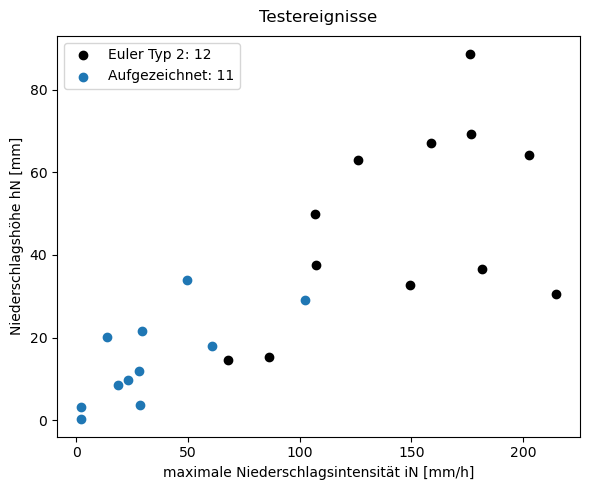

In [9]:
# Extract total precipitation and max intensity from seq_test
seq_test_trans = models[0]['seq_test_trans']
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')
ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


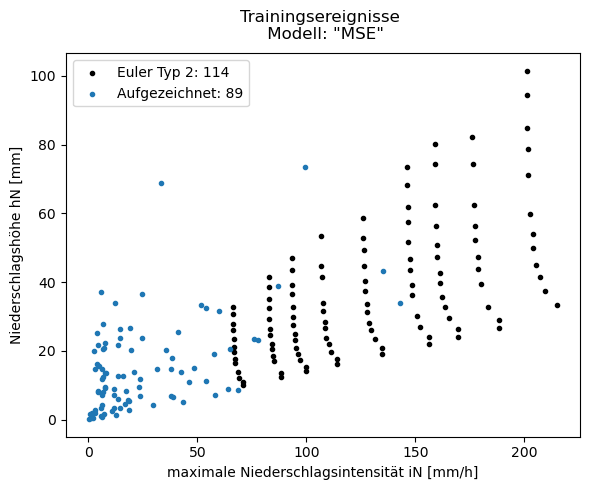

In [10]:
m = models[0]
train_e2_precip = [obj[0]['total precipitation'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Euler Typ 2']
train_e2_intensity = [obj[0]['max intensity'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Euler Typ 2']

train_measured_precip = [obj[0]['total precipitation'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Aufgezeichnet']
train_measured_intensity = [obj[0]['max intensity'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Aufgezeichnet']

# val_e2_precip = [obj[0]['total precipitation'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Euler Typ 2']
# val_e2_intensity = [obj[0]['max intensity'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Euler Typ 2']

# val_measured_precip = [obj[0]['total precipitation'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Aufgezeichnet']
# val_measured_intensity = [obj[0]['max intensity'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Aufgezeichnet']

train_precip = [obj[0]['total precipitation'] for obj in seq_train_trans]
train_intensity = [obj[0]['max intensity'] for obj in seq_train_trans]

# val_precip = [obj[0]['total precipitation'] for obj in seq_val_trans]
# val_intensity = [obj[0]['max intensity'] for obj in seq_val_trans]

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.scatter(train_e2_intensity, train_e2_precip, marker='.', color='black', label='Sample')
ax2.scatter(train_measured_intensity, train_measured_precip, marker='.', label='Events')
# ax2.plot( val_e2_intensity, val_e2_precip,'o', color='Black', label='Sample')
# ax2.scatter(val_measured_precip, val_measured_intensity, marker='x', color='Black', label='Events')

ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Trainingsereignisse \n Modell: ' + m['print_name'], pad=10)
# ax2.legend(labels=['Training (Euler Typ 2): {}'.format(len(train_e2_intensity)), 'Training (Aufgezeichnet): {}'.format(len(train_measured_precip)), 
#                 'Validierung (Euler Typ 2): {}'.format(len(val_e2_precip)), 'Validierung (Aufgezeichnet): {}'.format(len(val_measured_intensity))])
ax2.legend(labels=['Euler Typ 2: {}'.format(len(train_e2_intensity)), 'Aufgezeichnet: {}'.format(len(train_measured_precip))])
plt.tight_layout()

### Gesamtergebnisse der Modelle

**Auswertung des durchschnittlichen MSE der Kreuzvalidierung**

Bei jeder Modellerstellung werden die Daten zufällig in Trainings- und Validierungsdaten aufgeteilt. Die Balken zeigen den durchschnittlichen MSE der Kreuzvalidierung für die Trainings- und Validierungsdaten.

Hierbei ist zu beachten, dass diese Metrik vor der Datentransformation berechnet wurde und somit nur in diesem Verlgleich aussagekraft habe und mit nachfolgenden Metriken nicht vergleichbar ist.

Durchschnittlicher MSE:

+--------+----------+-------------+
| Modell | Training | Validierung |
+--------+----------+-------------+
| "MSE"  | 0.00084  |   0.00086   |
| "MAE"  | 0.00445  |   0.00467   |
+--------+----------+-------------+


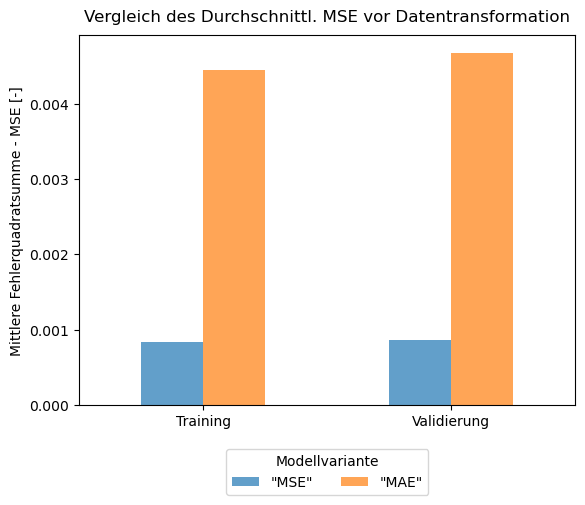

In [11]:
# cross validation results
mse = pd.DataFrame()
metric = 'mse'
metric_upper = metric.upper()
for m in models:
    name = m['print_name']
    train_result = m['cv_scores']['loss'].mean()
    val_result = m['cv_scores']['val_loss'].mean()
    if val_result < 1 or train_result < 1:
        new_row = pd.DataFrame({'Modell':name,'Training': train_result, 'Validierung': val_result}, index=[0])
        mse = pd.concat([mse, pd.DataFrame(new_row)] , ignore_index=True)

ax = mse.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, title='Modellvariante')
ax.set_ylabel('Mittlere Fehlerquadratsumme - '+ metric_upper +' [-]')

ax.set_title('Vergleich des Durchschnittl. '+ metric_upper + ' vor Datentransformation', pad=10)

display(Markdown('**Auswertung des durchschnittlichen '+metric_upper+' der Kreuzvalidierung**'))
display(Markdown('Bei jeder Modellerstellung werden die Daten zufällig in Trainings- und Validierungsdaten aufgeteilt. Die Balken zeigen den durchschnittlichen '+metric_upper+' der Kreuzvalidierung für die Trainings- und Validierungsdaten.'))
display(Markdown('Hierbei ist zu beachten, dass diese Metrik vor der Datentransformation berechnet wurde und somit nur in diesem Verlgleich aussagekraft habe und mit nachfolgenden Metriken nicht vergleichbar ist.'))

display(Markdown('Durchschnittlicher MSE:'))
print(tabulate(round(mse, 5), headers='keys', tablefmt='pretty', showindex=False))
# Show the plot
plt.show()

## **Lernkurven**

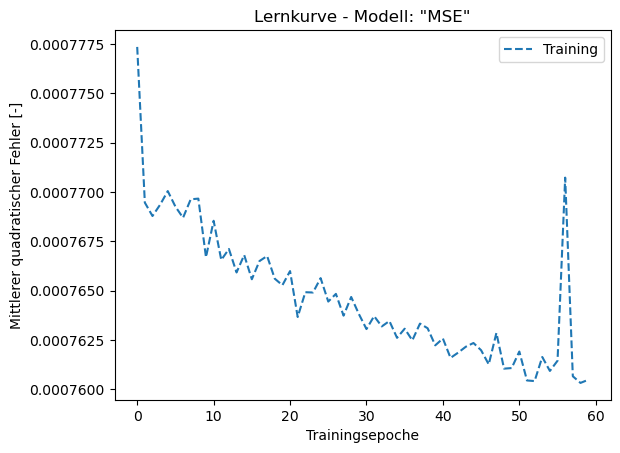

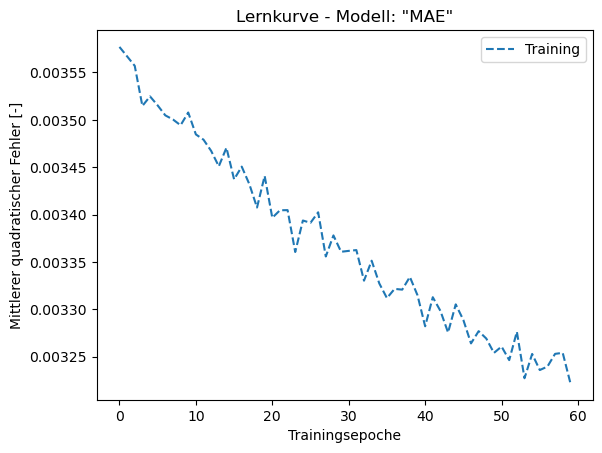

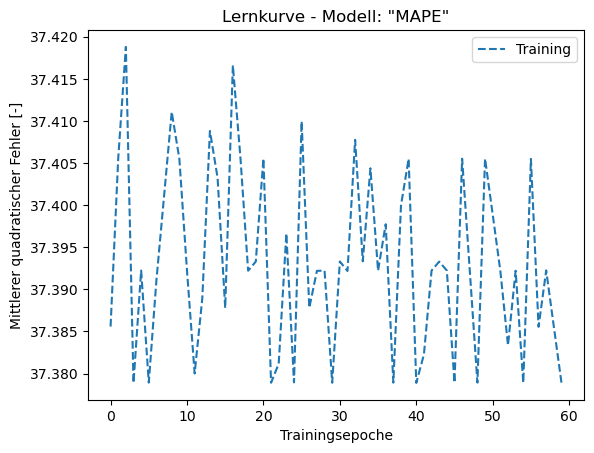

In [12]:
# Plot the learning curve
display(Markdown('## **Lernkurven**'))

for m in models:
    pyplot.plot(m['history']['loss'], '--', label='Training')
    if 'val_loss' in m['history']:
        pyplot.plot(m['history']['val_loss'], label='Validierung')
    pyplot.xlabel('Trainingsepoche')
    pyplot.ylabel('Mittlerer quadratischer Fehler [-]')
    pyplot.legend()
    pyplot.title('Lernkurve - Modell: ' + m['print_name'])
    pyplot.show()

**Auswertung nach RMSE**

+--------+----------+--------+
| Modell | Training |  Test  |
+--------+----------+--------+
| "MSE"  |  0.067   | 0.0739 |
| "MAE"  |  0.0659  | 0.0727 |
| "MAPE" |  0.2242  | 0.2541 |
+--------+----------+--------+


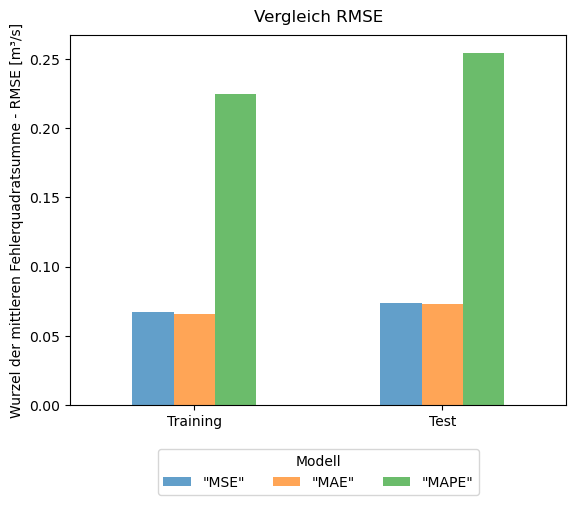

**Auswertung nach MAE**

+--------+----------+--------+
| Modell | Training |  Test  |
+--------+----------+--------+
| "MSE"  |  0.0092  | 0.0117 |
| "MAE"  |  0.008   | 0.0094 |
| "MAPE" |  0.0589  | 0.0734 |
+--------+----------+--------+


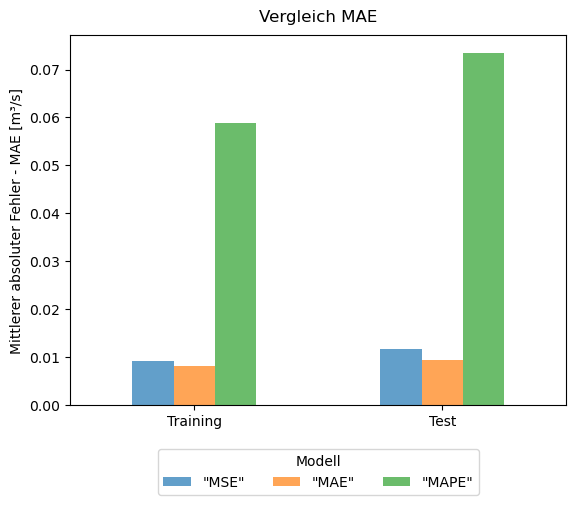

In [13]:
# Vergleich RMSE
metric_names = ('rmse', 'mae')
for m_name in metric_names:
    metrics = pd.DataFrame()
    name_upper = m_name.upper()
    for m in models:
        name = m['print_name']
        train_metric = m['train_eval'][m_name]
        # val_metric = m['val_eval'][m_name]
        test_metric = m['test_eval'][m_name]
        new_row = pd.DataFrame({'Modell':name,'Training': train_metric, 'Test': test_metric}, index=[0])
        # new_row = pd.DataFrame({'Modell':name,'Training': train_metric, 'Validierung': val_metric, 'Test': test_metric}, index=[0])
        metrics = pd.concat([metrics, pd.DataFrame(new_row)] , ignore_index=True)

    ax = metrics.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, title='Modell')
    ax.set_ylabel(metrics_labels[m_name])

    ax.set_title('Vergleich ' + name_upper, pad=10)

    # print(name_upper)
    display(Markdown('**Auswertung nach '+name_upper+'**'))
    print(tabulate(round(metrics, 4), headers='keys', tablefmt='pretty', showindex=False))

    # Show the plot
    plt.show()

### Modellauswertung nach Größenklassen der Ausgabewerte

In [14]:
import warnings
# Metrics based on Output magnitude
magnitude_metrics = []

for m in models:

    test_true_flattened = m['test_true'].flatten()
    test_pred_flattened = m['test_pred'].flatten()

    test_stack_flat = np.column_stack((test_true_flattened, test_pred_flattened))
    test_stack_flat = test_stack_flat[test_stack_flat[:, 0] != 0]
    test_stack_flat = pd.DataFrame(test_stack_flat, columns=['True', 'Pred'])

    # Get the value range of test_stack['True']
    value_range = np.ptp(test_stack_flat['True'])

    # Split the value range into 4 equal ranges
    ranges = np.linspace(0, np.max(test_stack_flat['True']), num=11)


    test_stack_flat['Bins'] = pd.cut(test_stack_flat['True'], bins=ranges, labels=False, include_lowest=True)
    ranges = np.round(ranges, 2)

    # Get unique bins
    unique_bins = test_stack_flat['Bins'].unique()
    unique_bins = sorted(unique_bins)



    # Create a list to store the datasets
    bins = []

    # Iterate over each unique bin
    for bin_num in unique_bins:
        # Filter the dataframe for the current bin
        bin_data = test_stack_flat[test_stack_flat['Bins'] == bin_num].copy()
        
        # Append the filtered dataset to the list
        bins.append(bin_data)

    metrics = pd.DataFrame([])
    metrics = pd.DataFrame(columns=['Bin', 'MSE','RMSE', 'MAE', 'MAPE', 'start', 'end', 'False_0', 'n'])
    i = 0
    for bin in bins:
        mse = np.mean((bin['True'] - bin['Pred'])**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(bin['True'] - bin['Pred']))
        mape = np.mean(np.abs((bin['True'] - bin['Pred']) / bin['True'])) * 100
        
        bin_start = ranges[i]
        bin_end = ranges[i+1]
        False_0 = len(bin[bin['Pred'] == 0])
        n = len(bin)

        new_row = pd.DataFrame({'Bin':i, 'MSE':mse,'RMSE':rmse, 'MAE':mae, 'MAPE':mape, 'start':bin_start, 'end':bin_end, 'False_0': False_0, 'n':n}, index=[0])

        i +=1
        
        metrics = pd.concat([metrics,new_row], ignore_index=True)
        
    
    magnitude_metrics.append(metrics)



i = 0
for metric in magnitude_metrics:
    metric[['MSE', 'MAE', 'RMSE']] = metric[['MSE', 'MAE', 'RMSE']].round(4)
    metric[['MAPE']] = metric[['MAPE']].round(2)
    print('Modell: ' + models[i]['print_name'])
    print(tabulate(metric, headers='keys', tablefmt='pretty', showindex=False))
    i += 1

warnings.filterwarnings("ignore")


Modell: "MSE"
+-----+--------+--------+--------+-------+-------+------+---------+------+
| Bin |  MSE   |  RMSE  |  MAE   | MAPE  | start | end  | False_0 |  n   |
+-----+--------+--------+--------+-------+-------+------+---------+------+
|  0  | 0.0006 | 0.0253 | 0.0118 | 19.05 |  0.0  | 0.24 |   742   | 8715 |
|  1  | 0.0089 | 0.0943 | 0.0428 | 13.13 | 0.24  | 0.49 |   39    | 519  |
|  2  | 0.0321 | 0.1793 | 0.0772 | 12.83 | 0.49  | 0.73 |   15    | 184  |
|  3  | 0.0592 | 0.2434 | 0.0989 | 11.95 | 0.73  | 0.97 |    7    |  85  |
|  4  | 0.1064 | 0.3261 | 0.1222 | 10.96 | 0.97  | 1.22 |    9    | 107  |
|  5  | 0.1618 | 0.4023 | 0.1495 | 11.36 | 1.22  | 1.46 |    4    |  43  |
|  6  | 0.1855 | 0.4307 | 0.156  | 10.11 | 1.46  | 1.7  |    2    |  26  |
|  7  |  0.24  | 0.4899 | 0.1653 |  9.2  |  1.7  | 1.95 |    4    |  54  |
|  8  | 0.3429 | 0.5856 | 0.2076 | 10.03 | 1.95  | 2.19 |    5    |  63  |
|  9  | 0.477  | 0.6906 | 0.234  | 10.1  | 2.19  | 2.43 |    7    |  79  |
+-----+----

C:\Users\fl-al\AppData\Local\Temp\ipykernel_28916\4241526601.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics,new_row], ignore_index=True)
C:\Users\fl-al\AppData\Local\Temp\ipykernel_28916\4241526601.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics,new_row], ignore_index=True)
C:\Users\fl-al\AppData\Local\Temp\ipykernel_28916\4241526601.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

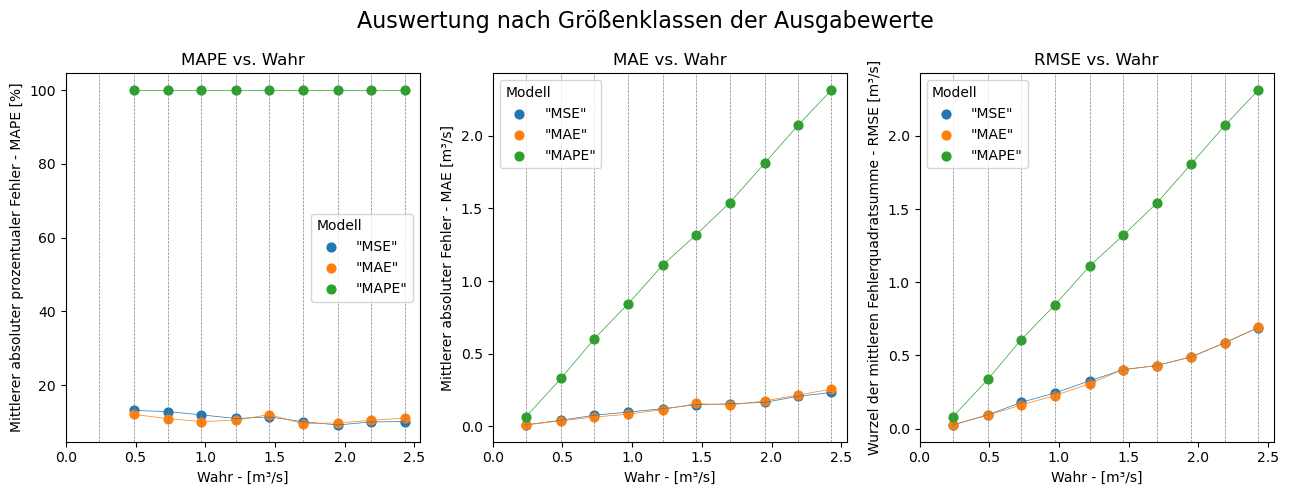

In [15]:
metrics = ('MAPE', 'MAE', 'RMSE')


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

j = 0
for metric in metrics:
    i = 0
    for m in magnitude_metrics:
        if metric == 'MAPE':
            x = m['end'].iloc[1:]
            y = m[metric].iloc[1:]
        else:
            x = m['end']
            y = m[metric]
        
        # print(m)
        axs[j].scatter(x, y, label = models[i]['print_name'], marker='o', s=40)
        axs[j].plot(x, y, linewidth=0.5)
        i += 1
    axs[j].set_xlabel('Wahr - ['+ out_unit + ']')
    axs[j].set_ylabel(metrics_labels[metric.lower()])
    for border in magnitude_metrics[0]['end']:
        axs[j].axvline(x=border, color = 'grey', linestyle='--', linewidth=0.5)
    axs[j].set_title(metric + ' vs. Wahr')
    axs[j].set_xlim(0,None)

    axs[j].legend(title="Modell", fancybox=True)._legend_box.align = "left"
    
    j += 1

fig.suptitle('Auswertung nach Größenklassen der Ausgabewerte', fontsize=16)
plt.tight_layout()
plt.show()

### Darstellung aller Vorhersagen und Residuen

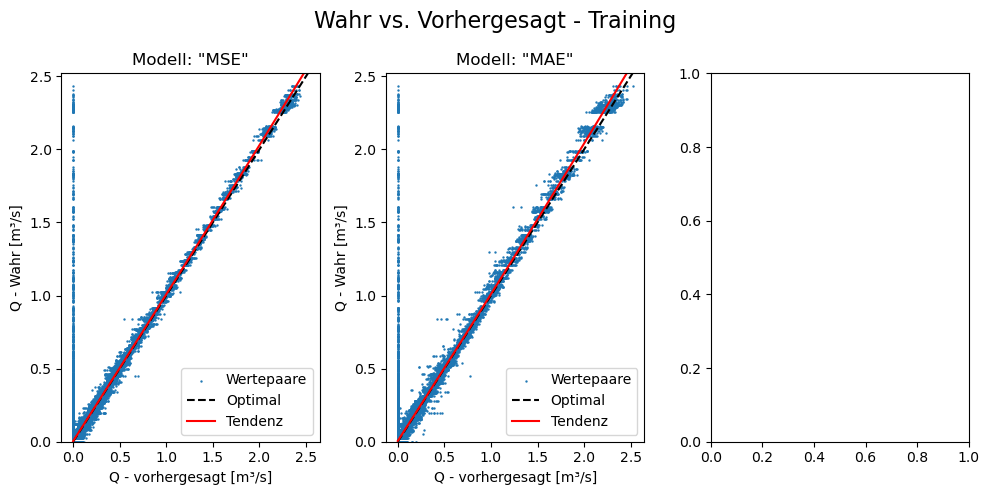

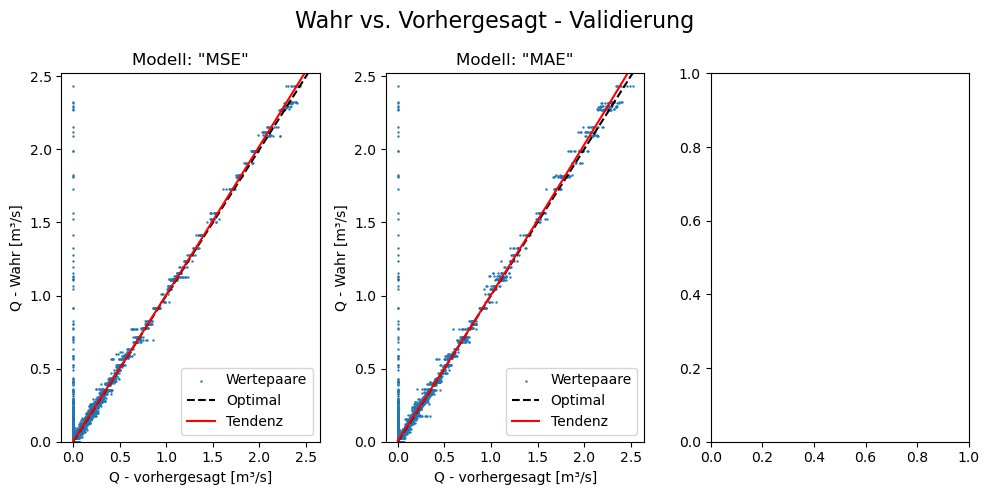

In [16]:
# Plot True vs. Predicted
cols = ['Modell: {}'.format(m_name['print_name']) for m_name in models]
rows = ['{}'.format(row) for row in ['Training', 'Validierung', 'Test']]

m_trues = []
m_preds = []
mins =[]
maxs = []

for m in models:
    # Calculate the regression line using polynomial fit
    train_pred_flat = m['train_pred'].flatten()
    train_true_flat = m['train_true'].flatten()
    # val_pred_flat = m['val_pred'].flatten()
    # val_true_flat = m['val_true'].flatten()
    test_pred_flat = m['test_pred'].flatten()
    test_true_flat = m['test_true'].flatten()
    names = ['Training', 'Test']
    preds = [train_pred_flat, test_pred_flat]
    trues = [train_true_flat, test_true_flat]
    # names = ['Training', 'Validierung', 'Test']
    # preds = [train_pred_flat, val_pred_flat, test_pred_flat]
    # trues = [train_true_flat, val_true_flat, test_true_flat]
    min_value = min(min(r) for r in preds)
    max_value = max(max(r) for r in preds)
    mins.append(min_value)
    maxs.append(max_value)
    m_preds.append(preds)
    m_trues.append(trues)

min_val = min(mins)
max_val = max(maxs)
regression_range = np.linspace(min_val, max_val, 100)

# Plot if only one model is given
if len(m_preds) == 1:
    for j in range(len(m_preds)):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

        for i in range(len(m_preds[j])):
            # Create a figure and subplots

            reg_line = np.polyfit(m_preds[j][i], m_trues[j][i], 2)
            reg_line_fn = np.poly1d(reg_line)
            # Plot train_pred/train_resid
            axs[i].scatter(m_preds[j][i], m_trues[j][i], marker ='.', s= 2, label = 'Wertepaare')
            axs[i].set_title(names[i])
            axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
            axs[i].set_ylabel('Q - Wahr ['+ out_unit + ']')    
            # Plot the average line
            axs[i].plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Optimal')
            # Plot the regression line
            axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Tendenz')
            axs[i].legend()
            axs[i].set_ylim(min_val, max_val)
            axs[i].legend()

    fig.suptitle('Wahr vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
    plt.show()

# Plot if more than one model are given
else:
    for j in range(len(m_preds[0])):
        fig, axs = plt.subplots(ncols=len(models),figsize=(10, 5))

        for i in range(len(m_preds)):
            try:
                # Create a figure and subplots

                reg_line = np.polyfit(m_preds[i][j], m_trues[i][j], 2)
                reg_line_fn = np.poly1d(reg_line)
                # Plot train_pred/train_resid
                axs[i].scatter(m_preds[i][j], m_trues[i][j], marker ='.', s= 2, label = 'Wertepaare')
                axs[i].set_title(cols[i])
                axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
                axs[i].set_ylabel('Q - Wahr ['+ out_unit + ']')    
                # Plot the average line
                axs[i].plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Optimal')
                # Plot the regression line
                axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Tendenz')
                axs[i].legend()
                axs[i].set_ylim(min_val, max_val)
                axs[i].legend()
            except:
                pass
        fig.suptitle('Wahr vs. Vorhergesagt - ' + rows[j], fontsize=16)
        fig.tight_layout()
        plt.show()

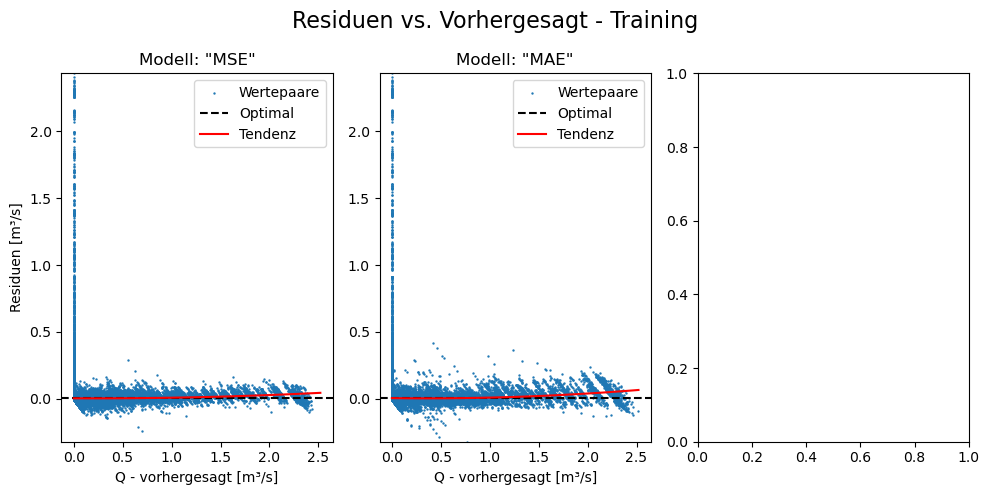

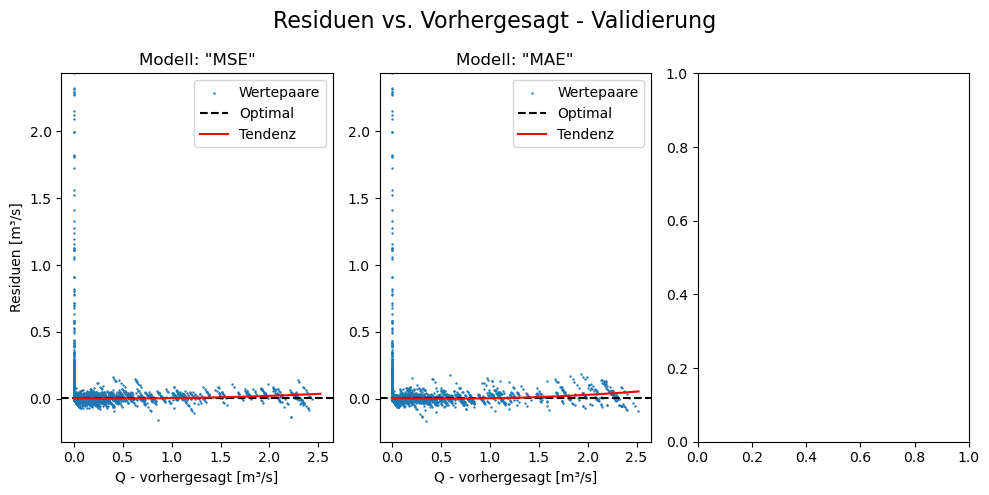

In [17]:
# Plot True vs. Predicted
cols = ['Modell: {}'.format(m_name['print_name']) for m_name in models]
rows = ['{}'.format(row) for row in ['Training', 'Validierung', 'Test']]

m_resids = []
m_preds = []
mins =[]
maxs = []
maxs_preds = []
for m in models:
    # Calculate the regression line using polynomial fit
    train_pred_flat = m['train_pred'].flatten()
    train_resid = m['train_resid']
    # val_pred_flat = m['val_pred'].flatten()
    # val_resid = m['val_resid']
    test_pred_flat = m['test_pred'].flatten()
    test_resid = m['test_resid']
    names = ['Training', 'Test']
    preds = [train_pred_flat, test_pred_flat]
    resids = [train_resid, test_resid]
    # names = ['Training', 'Validierung', 'Test']
    # preds = [train_pred_flat, val_pred_flat, test_pred_flat]
    # resids = [train_resid, val_resid, test_resid]
    min_value = min(min(r) for r in resids)
    max_value = max(max(r) for r in resids)
    max_pred = max(max(p) for p in preds)
    mins.append(min_value)
    maxs.append(max_value)
    maxs_preds.append(max_pred)
    m_preds.append(preds)
    m_resids.append(resids)
max_pred_val = max(maxs_preds)
min_val = min(mins)
max_val = max(maxs)
regression_range = np.linspace(0, max_pred_val, 100)

# Plot if only one model is given
if len(m_preds) == 1:
    for j in range(len(m_preds)):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

        for i in range(len(m_preds[j])):
            try:
                # Create a figure and subplots
                
                reg_line = np.polyfit(m_preds[j][i], m_resids[j][i], 2)
                reg_line_fn = np.poly1d(reg_line)
                # Plot train_pred/train_resid
                axs[i].scatter(m_preds[j][i], m_resids[j][i], marker ='.', s= 2,label='Wertepaare')
                axs[i].set_title(names[i])
                axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
                if i == 0:
                    axs[i].set_ylabel('Residuen ['+ out_unit + ']')
                # Plot the average line
                axs[i].axhline(np.mean(m_resids[j][i]), color='black', linestyle='--', label='Optimal')
                # Plot the regression line
                axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Tendenz')
                axs[i].legend()
                axs[i].set_ylim(min_val, max_val)
                axs[i].legend()
            except:
                pass
        fig.suptitle('Residuen vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
        # Show the plot
        plt.show()

# Plot if more than one model are given
else:
    for j in range(len(m_preds[0])):
        fig, axs = plt.subplots(ncols=len(models),figsize=(10, 5))
        for i in range(len(m_preds)):
            try:
                reg_line = np.polyfit(m_preds[i][j], m_resids[i][j], 2)
                reg_line_fn = np.poly1d(reg_line)
                # Plot train_pred/train_resid
                axs[i].scatter(m_preds[i][j], m_resids[i][j], marker ='.', s= 2,label='Wertepaare')
                axs[i].set_title(cols[i])
                axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
                if i == 0:
                    axs[i].set_ylabel('Residuen ['+ out_unit + ']')
                # Plot the average line
                axs[i].axhline(np.mean(m_resids[i][j]), color='black', linestyle='--', label='Optimal')
                # Plot the regression line
                axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Tendenz')
                axs[i].legend()
                axs[i].set_ylim(min_val, max_val)
                axs[i].legend()
            except:
                pass
        fig.suptitle('Residuen vs. Vorhergesagt - ' + rows[j], fontsize=16)
        fig.tight_layout()
        plt.show()

In [18]:
# n_sample = 3
# n = 15
# # test for plot_seq_i_d_Q function
# for m in models:
#     seq_test = m['seq_test']
#     seq_test_trans = m['seq_test_trans']
#     model = m['model']

#     interval = seq_test[n_sample][0]['interval']
#     meta = seq_test[n_sample][0]
#     in_seq = seq_test[n_sample][1][n]
#     out_act = seq_test[n_sample][2][n]

#     # Calculate the start and end time of the sequence so that a duration column can be created
#     start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
#     end_time = start_time + p_steps * interval
#     duration_col = np.arange(start_time, end_time, interval)

#     Predict = model.predict(seq_test_trans[n_sample][1])
#     Predict_invert = out_scaler.inverse_transform(Predict)

#     predict_seq = np.column_stack((duration_col,Predict_invert[n]))
#     actual_seq = np.column_stack((duration_col,out_act))


#     plot_seq_i_d_Q(in_seq, actual_seq, predict_seq, meta, interval,).show()

### Auswertung der Extremwertabweichung im Testdatensatz

+----------+-----------+------------+------------+
| Modell   |   MAE [-] |   RMSE [-] |   MAPE [%] |
|----------+-----------+------------+------------|
| "MSE"    | 0.0276034 |  0.0373998 |    5.24152 |
| "MAE"    | 0.0293784 |  0.0372595 |    4.11769 |
| "MAPE"   | 1.26587   |  1.58058   |  100       |
+----------+-----------+------------+------------+


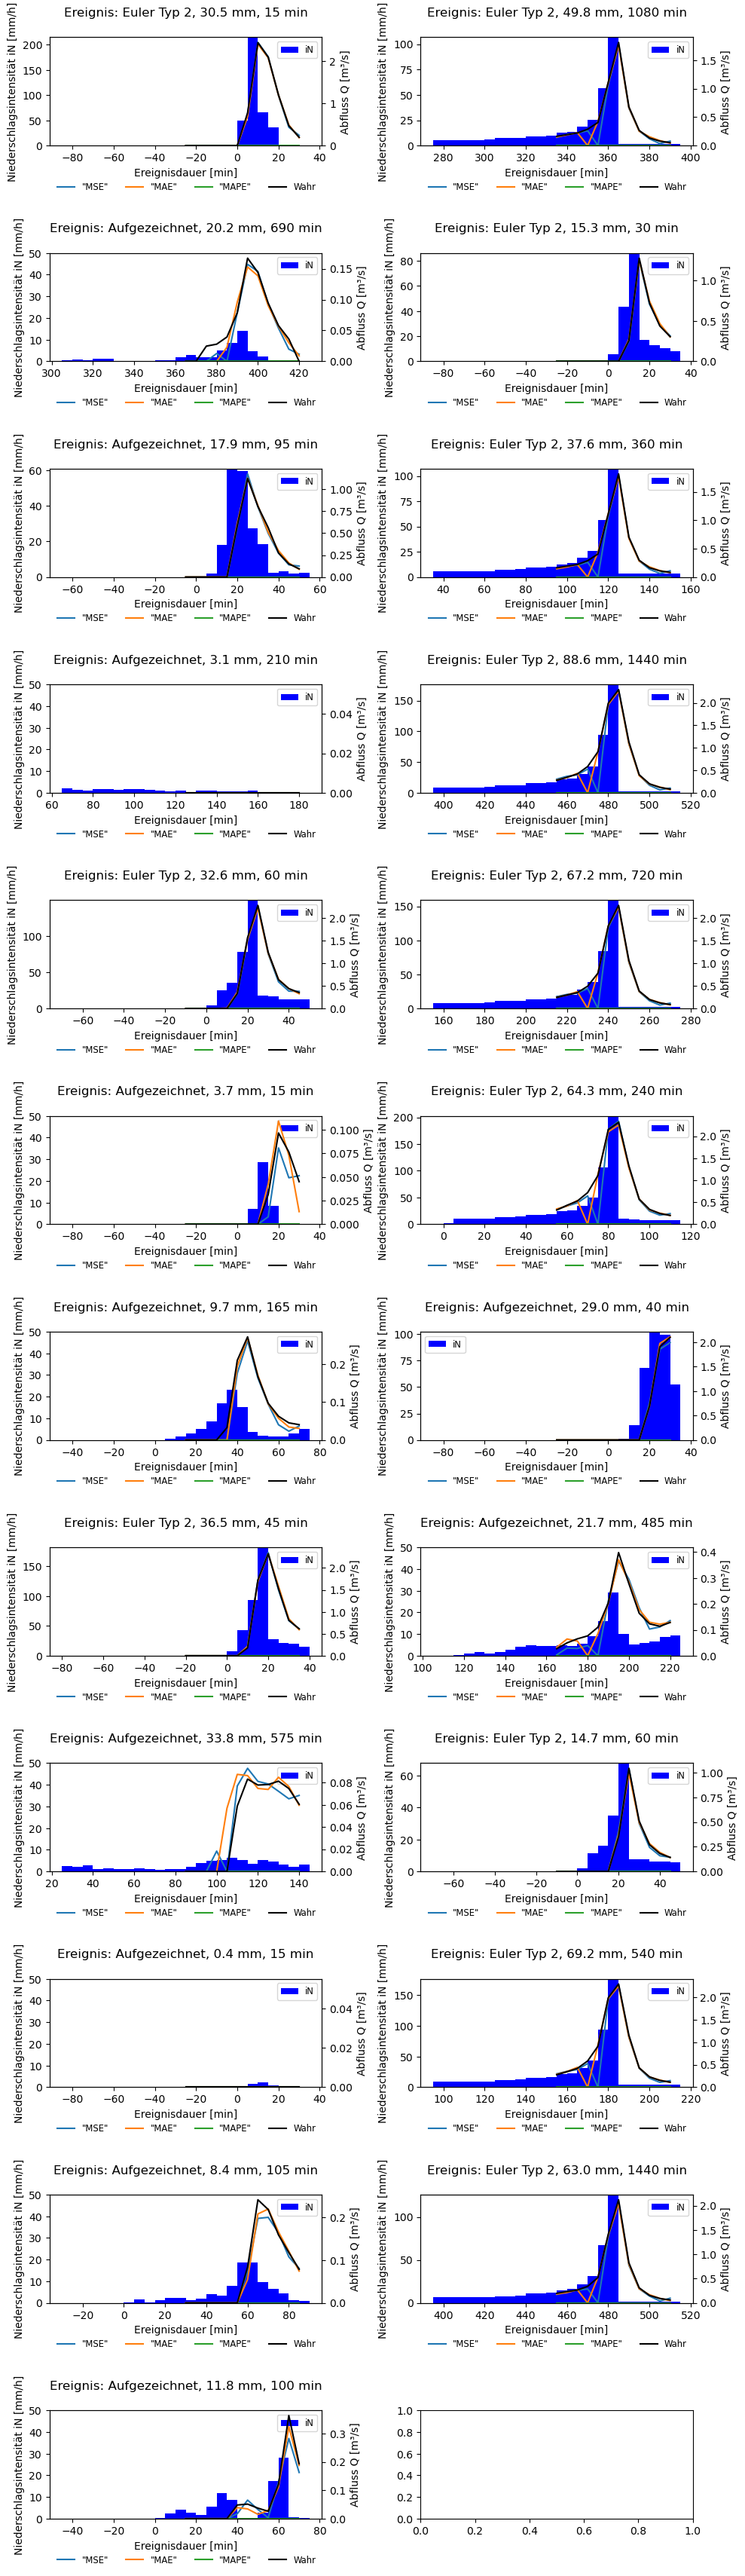

In [19]:
# Plot predict and plot the peak time steps of each event and calculate the peak metrics
#retrieve the interval of the time steps
interval = models[0]['seq_test'][0][0]['interval']

# Create a grid of subplots
plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1.5*len(seq_test_trans)))

abs_errors = [np.array([]) for _ in range(len(models))]
sqrt_errors = abs_errors.copy()
abs_prct_errors = abs_errors.copy()
# Loop through n_sample
for n_sample in range(len(seq_test_trans)):
    # n = 12 +int((len(seq_test[n_sample][1])-24) / 3)
    # n = int(len(seq_test[n_sample][1]) / 5)
    n = np.argmax(seq_test[n_sample][2][:, 0, 0])
    n = n - p_steps/2
    n = n.astype(int)

    # Calculate the start and end time of the sequence so that a duration column can be created
    start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    duration_col = np.arange(start_time, end_time, interval)

    actual_seq = np.column_stack((duration_col,seq_test[n_sample][2][n]))
    
    # Dictionary of event meta data
    meta = seq_test[n_sample][0] #'name': sample_name, 'duration': event_duration, 'total precipitation': precip_sum, 'max intensity': max_intensity, 'interval': intervall, 'Ereignis': type

    # Calculate column index for the subplot. Only important for plot!!
    col_index = n_sample % 2
 
    # Create Barplot of Precipitation
    ax1 = axs[n_sample // 2, col_index]
    ax1.set_title(f"Ereignis: {meta['event type']}, {round(meta['total precipitation'],1)} mm, {meta['duration']} min", pad=20)
    x = seq_test[n_sample][1][n][:,0]  # Set x-axis values
    ax1.bar(x, seq_test[n_sample][1][n][:,1], color='blue', label='iN', width=interval, align='edge')
    top_lim = max(max(seq_test[n_sample][1][n][:,1]), 50)
    ax1.set_ylim(bottom=0, top=top_lim)  # Set y-axis to start from zero
    ax1.set_ylabel('Niederschlagsintensität iN [mm/h]')
    ax1.set_xlabel('Ereignisdauer [min]')
    ax1.legend(fontsize = 'small')

    # Create a twin axis on the right side
    # Plotting the predicted and actual values in the corresponding subplot
    ax2 = ax1.twinx()
    i = 0
    for m in models:
        seq_test = m['seq_test']
        seq_test_trans = m['seq_test_trans']
        model = m['model']

        interval = seq_test[n_sample][0]['interval']
        meta = seq_test[n_sample][0]
        in_seq = seq_test[n_sample][1][n]
        out_act = seq_test[n_sample][2][n]

        # Calculate the start and end time of the sequence so that a duration column can be created
        start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
        end_time = start_time + p_steps * interval
        duration_col = np.arange(start_time, end_time, interval)

        Predict = model.predict(seq_test_trans[n_sample][1], verbose=0)
        Predict_invert = out_scaler.inverse_transform(Predict)

        predict_seq = np.column_stack((duration_col,Predict_invert[n]))
        ax2.plot(predict_seq[:, 0], predict_seq[:, 1], label=m['print_name'])
        argmax = np.argmax(actual_seq[:, 1])
        actual_max = actual_seq[argmax, 1]
        predict_max = predict_seq[argmax, 1]
        extreme_abs_error = abs(actual_max - predict_max)
        extreme_squared_error = extreme_abs_error**2
        sqrt_errors[i] = np.append(sqrt_errors[i], extreme_squared_error)
        abs_errors[i] = np.append(abs_errors[i], extreme_abs_error)
        abs_prct_errors[i] = np.append(abs_prct_errors[i], extreme_abs_error / actual_max * 100)
        i+=1

    ax2.plot(actual_seq[:, 0], actual_seq[:, 1], color = 'black', label='Wahr')
    ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax2.set_ylabel('Abfluss Q [m³/s]')
    ax2.legend(loc='lower left', bbox_to_anchor=(0, -0.5), frameon=False, ncol = len(models)+1, fontsize = 'small')
    
peak_maes = []
peak_rmses = []
peak_mapes = []

for i in range(len(abs_errors)):
    mae = np.mean(abs_errors[i])
    rmse = np.sqrt(np.mean(sqrt_errors[i]))
    ape = abs_prct_errors[i][~np.isnan(abs_prct_errors[i])]
    mape = np.mean(ape)
    peak_maes.append(mae)
    peak_rmses.append(rmse)
    peak_mapes.append(mape)

peak_eval = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'MAE [-]': peak_maes,
    'RMSE [-]': peak_rmses,
    'MAPE [%]': peak_mapes
})

print(tabulate(peak_eval, headers='keys', tablefmt='psql', showindex=False))

plt.tight_layout()
# Show the plot
plt.show()
